# Homework 13 - Network Compression

**助教禁止 pseduo label on test data 防止 overfitting，但這也是個增加 training data 的方法**

Author: Liang-Hsuan Tseng (b07502072@ntu.edu.tw), modified from ML2021-HW13

If you have any questions, feel free to ask: ntu-ml-2022spring-ta@googlegroups.com

[**Link to HW13 Slides**](https://docs.google.com/presentation/d/1nCT9XrInF21B4qQAWuODy5sonKDnpGhjtcAwqa75mVU/edit#slide=id.p)

ref
* https://github.com/AberHu/Knowledge-Distillation-Zoo

### Outline

* [Packages](#Packages) - intall some required packages.
* [Dataset](#Dataset) - something you need to know about the dataset.
* [Configs](#Configs) - the configs of the experiments, you can change some hyperparameters here.
* [Architecture_Design](#Architecture_Design) - depthwise and pointwise convolution examples and some useful links.
* [Knowledge_Distillation](#Knowledge_Distillation) - KL divergence loss for knowledge distillation and some useful links.
* [Training](#Training) - training loop implementation modified from HW3.
* [Inference](#Inference) - create submission.csv by loading the best.ckpt from the .



In [11]:
!nvidia-smi

NVIDIA-SMI has failed because it couldn't communicate with the NVIDIA driver. Make sure that the latest NVIDIA driver is installed and running.



### Packages
First, we need to import some useful packages. Since the `torchsummary` package is not installed by default, we have to install it via `pip` manually.

In [12]:
!pip install torchinfo

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [13]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# Import some useful packages for this homework
import numpy as np
import pandas as pd
import os
from PIL import Image
from tqdm.auto import tqdm
import random
from pprint import pprint
import matplotlib.pyplot as plt
import math

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import ConcatDataset, DataLoader, Subset, Dataset # "ConcatDataset" and "Subset" are possibly useful.
from torchvision.datasets import DatasetFolder, VisionDataset

from torchinfo import summary

### Configs
In this part, you can specify some variables and hyperparameters as your configs.

In [14]:
cfg = {
    'dataset_root': '/kaggle/input/ml2022spring-hw13/food11-hw13',
    'save_dir': '/kaggle/working/outputs',
    'exp_name': "ResNet18_prune_MIX_DML",
    'batch_size': 32,
    'seed': 3,
    'loss_fn_type': 'MIX', # simple baseline: CE, medium baseline: KD. See the Knowledge_Distillation part for more information.
    'weight_decay': 1e-5,
    'grad_norm_max': 10,
    'n_epochs': 140,
    'patience': 300,
    
    # SGD
    "momentum": 0.9, 
    "weight_decay": 0.0001,
    
    # lr step
    'lr': 3e-3,
    'milestones': [100,170],
    'lr_decay': 0.5,
    
    # KD
    'alpha': 0.9,
    'temperature': 10,
    
    # RKD
    'w_dist': 1.0,
    'w_angle': 2.0,
    'lamda': 1.0,
}

In [15]:
myseed = cfg['seed']  # set a random seed for reproducibility
def same_seeds(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True
    
same_seeds(myseed)

In [16]:
cuda = True if torch.cuda.is_available() else False
device = torch.device('cuda:0' if cuda else 'cpu')
FloatTensor = torch.cuda.FloatTensor if cuda else torch.FloatTensor
device

device(type='cpu')

In [17]:
save_path = os.path.join(cfg['save_dir'], cfg['exp_name']) # create saving directory
os.makedirs(save_path, exist_ok=True)

# define simple logging functionality
log_fw = open(f"{save_path}/log.txt", 'w') # open log file to save log outputs
def log(text):     # define a logging function to trace the training process
    pprint(text, width=150)
    log_fw.write(str(text)+'\n')
    log_fw.flush()

log(cfg)  # log your configs to the log file
log(f"device: {device}")

{'alpha': 0.9,
 'batch_size': 32,
 'dataset_root': '/kaggle/input/ml2022spring-hw13/food11-hw13',
 'exp_name': 'ResNet18_prune_MIX_DML',
 'grad_norm_max': 10,
 'lamda': 1.0,
 'loss_fn_type': 'MIX',
 'lr': 0.003,
 'lr_decay': 0.5,
 'milestones': [100, 170],
 'momentum': 0.9,
 'n_epochs': 140,
 'patience': 300,
 'save_dir': '/kaggle/working/outputs',
 'seed': 3,
 'temperature': 10,
 'w_angle': 2.0,
 'w_dist': 1.0,
 'weight_decay': 0.0001}
'device: cpu'


### Dataset
We use Food11 dataset for this homework, which is similar to homework3. But remember, Please DO NOT utilize the dataset of HW3. We've modified the dataset, so you should only access the dataset by loading it in this kaggle notebook or through the links provided in the HW13 colab notebooks.

In [18]:
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory
for dirname, _, filenames in os.walk('/kaggle/input'):
    if len(filenames) > 0:
        print(f"{dirname}: {len(filenames)} files.") # Show the .jpg file amounts in each split.

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [19]:
def no_axis_show(img, title='', cmap=None):
    # imshow, and set the interpolation mode to be "nearest"。
    fig = plt.imshow(img, interpolation='nearest', cmap=cmap)
    # do not show the axes in the images.
    fig.axes.get_xaxis().set_visible(False)
    fig.axes.get_yaxis().set_visible(False)
    plt.title(title)

FileNotFoundError: ignored

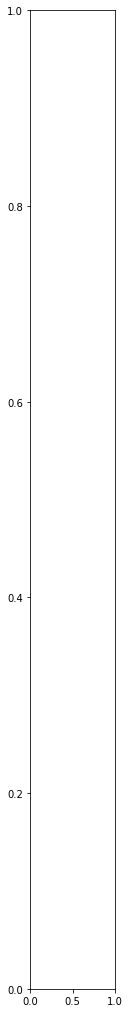

In [20]:
titles = ["Bread", "Dairy product", "Dessert", "Egg", "Fried food", "Meat", "Noodles/Pasta", "Rice", "Seafood", "Soup", "Vegetable/Fruit"]
for i in range(11):
    plt.figure(figsize=(18, 18))
    for j in range(10):
        plt.subplot(1, 10, j+1)
        fig = no_axis_show(plt.imread(f'../input/ml2022spring-hw13/food11-hw13/training/{i}_{j}.jpg'), title=titles[i])
    plt.show()

In [ ]:
def tensor_show(imgs, size_inches=(15, 10)):
    if not isinstance(imgs, list):
        imgs = [imgs]
    fig, axs = plt.subplots(ncols=len(imgs), squeeze=False)
    fig.set_size_inches(*size_inches)
    for i, img in enumerate(imgs):
        img = torchvision.transforms.functional.to_pil_image(img)
        axs[0, i].imshow(np.asarray(img))
        axs[0, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])
    plt.show()

Next, specify train/valid transform for image data augmentation.
Torchvision provides lots of useful utilities for image preprocessing, data wrapping as well as data augmentation.

Please refer to [PyTorch official website](https://pytorch.org/vision/stable/transforms.html) for details about different transforms. You can also apply the knowledge or experience you learned in HW3.

In [ ]:
MEAN = torch.tensor([0.485, 0.456, 0.406]).to(device)
STD = torch.tensor([0.229, 0.224, 0.225]).to(device)

normalize = transforms.Normalize(mean=MEAN, std=STD)
# define training/testing transforms
test_tfm = transforms.Compose([
    # It is not encouraged to modify this part if you are using the provided teacher model. This transform is stardard and good enough for testing.
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    normalize,
])

train_tfm = transforms.Compose([
    # add some useful transform or augmentation here, according to your experience in HW3.
    transforms.RandomResizedCrop(size=256, scale=(0.8, 1.0)),#随机裁剪到256*256
#     transforms.Resize(256),  # You can change this
    transforms.CenterCrop(224), # You can change this, but be aware of that the given teacher model's input size is 224.
    # The training input size of the provided teacher model is (3, 224, 224).
    # Thus, Input size other then 224 might hurt the performance. please be careful.
    transforms.RandomHorizontalFlip(), # You can change this.
    transforms.RandomRotation(15),
    transforms.ToTensor(),
    normalize,
])

In [ ]:
class FoodDataset(Dataset):
    def __init__(self, path, tfm=test_tfm, files=None):
        super().__init__()
        self.path = path
        self.files = sorted([os.path.join(path,x) for x in os.listdir(path) if x.endswith(".jpg")])
        if files != None:
            self.files = files
        print(f"One {path} sample",self.files[0])
        self.transform = tfm
  
    def __len__(self):
        return len(self.files)
  
    def __getitem__(self,idx):
        fname = self.files[idx]
        im = Image.open(fname)
        im = self.transform(im)
        try:
            label = int(fname.split("/")[-1].split("_")[0])
        except:
            label = -1 # test has no label
        return im, label

In [ ]:
train_set = FoodDataset(os.path.join(cfg['dataset_root'], "training"), tfm=train_tfm)
# train_loader = DataLoader(train_set, batch_size=cfg['batch_size'], shuffle=True, num_workers=0, pin_memory=True)

valid_set = FoodDataset(os.path.join(cfg['dataset_root'], "validation"), tfm=train_tfm)
# valid_set = FoodDataset(os.path.join(cfg['dataset_root'], "validation"), tfm=test_tfm)
# valid_loader = DataLoader(valid_set, batch_size=cfg['batch_size'], shuffle=False, num_workers=0, pin_memory=True)

concat_set = ConcatDataset([train_set, valid_set])
train_loader = DataLoader(concat_set, batch_size=cfg['batch_size'], shuffle=True, num_workers=0, pin_memory=True)

eval_set = FoodDataset(os.path.join(cfg['dataset_root'], "evaluation"), tfm=test_tfm)
eval_loader = DataLoader(eval_set, batch_size=cfg['batch_size'], shuffle=False, num_workers=0, pin_memory=True)

In [ ]:
recover_from_normalize = lambda img: img * STD[:, None, None] + MEAN[:, None, None]

imgs = iter(train_loader).next()[0][:30]
grid = torchvision.utils.make_grid([recover_from_normalize(img.to(device)) for img in imgs], nrow=10)
tensor_show(grid, size_inches=(15, 5))

# imgs = iter(valid_loader).next()[0][:30]
# grid = torchvision.utils.make_grid([recover_from_normalize(img.to(device)) for img in imgs], nrow=10)
# tensor_show(grid, size_inches=(15, 5))

imgs = iter(eval_loader).next()[0][:30]
grid = torchvision.utils.make_grid([recover_from_normalize(img.to(device)) for img in imgs], nrow=10)
tensor_show(grid, size_inches=(15, 5))

In [ ]:
def get_valid_acc(model, data_loader, ratio=0.0):  
    model.to(device)
    # ---------- Validation ----------
    # Make sure the model is in eval mode so that some modules like dropout are disabled and work normally.
    model.eval()

    # These are used to record information in validation.
    valid_accs = []
    valid_lens = []

    # Iterate the validation set by batches.
    progress_bar = tqdm(data_loader)
    progress_bar.set_description(f"Ratio:{ratio:.2f}")
    for batch in progress_bar:
        # A batch consists of image data and corresponding labels.
        imgs, labels = batch
        imgs = imgs.to(device)
        labels = labels.to(device)
        logits = model(imgs)
        logits = logits[-1]

        # Compute the accuracy for current batch.
        acc = (logits.argmax(dim=-1) == labels).float().sum()

        # Record accuracy.
        batch_len = len(imgs)
        valid_accs.append(acc)
        valid_lens.append(batch_len)

    valid_acc = sum(valid_accs) / sum(valid_lens)
    
    return valid_acc

### Architecture_Design

In this homework, you have to design a smaller network and make it perform well. Apparently, a well-designed architecture is crucial for such task. Here, we introduce depthwise and pointwise convolutions. They are some common techniques for architecture design when it comes to network compression.

<img src="https://i.imgur.com/LFDKHOp.png" width=400px>

* explanation of depthwise and pointwise convolutions:
    * [prof. Hung-yi Lee's slides(p.24~p.30, especially p.28)](https://speech.ee.ntu.edu.tw/~hylee/ml/ml2021-course-data/tiny_v7.pdf)

In [ ]:
# Example implementation of Depthwise and Pointwise Convolution 
# https://www.cnblogs.com/wanghui-garcia/p/10775851.html
def DWPW_Conv2d(in_channels, out_channels, kernel_size, stride=1, padding=0, bias=True):
    # depthwise convolution
    depthwise_conv = nn.Conv2d(in_channels, 
                               in_channels, 
                               kernel_size, 
                               stride=stride, 
                               padding=padding, 
                               groups=in_channels,
                               bias=bias)
    assert depthwise_conv.weight.data.size() == (in_channels, 1, kernel_size, kernel_size)
    # pointwise convolution
    pointwise_conv = nn.Conv2d(in_channels, out_channels, 1, bias=bias)
    assert pointwise_conv.weight.data.size() == (out_channels, in_channels, 1, 1)
    return nn.Sequential(
        depthwise_conv,
        pointwise_conv,
    )

* other useful techniques and popular network architecture designs for network compression
    * [group convolution](https://www.researchgate.net/figure/The-transformations-within-a-layer-in-DenseNets-left-and-CondenseNets-at-training-time_fig2_321325862) (Actually, depthwise convolution is a specific type of group convolution)
    * [SqueezeNet](https://arxiv.org/abs/1602.07360)
    * [MobileNet](https://arxiv.org/abs/1704.04861)
    * [ShuffleNet](https://arxiv.org/abs/1707.01083)
    * [Xception](https://arxiv.org/abs/1610.02357)
    * [GhostNet](https://arxiv.org/abs/1911.11907)


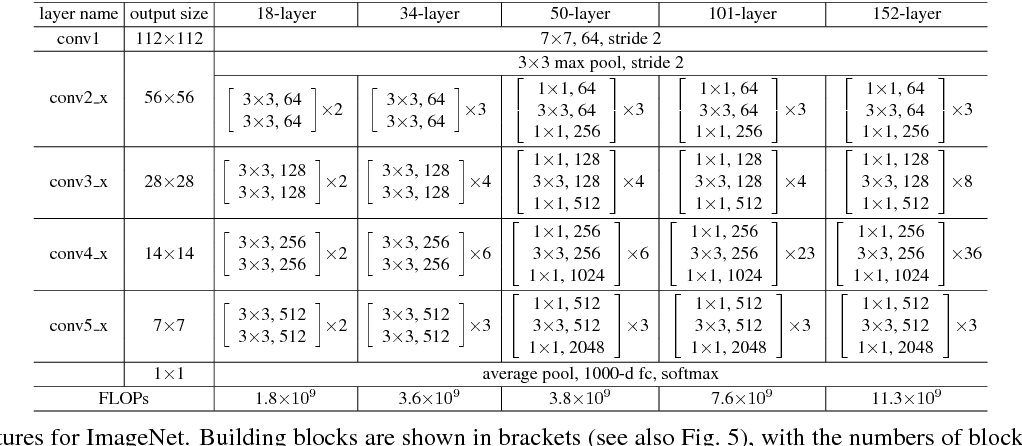

#### ResNest9
https://jovian.ai/neha-prajapati/intel-image-classification-using-resnet9

In [ ]:
def dwpw_conv_block(in_channels, out_channels, pool=False):
    layers = [DWPW_Conv2d(in_channels, out_channels, kernel_size = 3, padding = 1), 
              nn.BatchNorm2d(out_channels), 
              nn.ReLU(inplace = True)]
    if pool: layers.append(nn.MaxPool2d(2))
    return nn.Sequential(*layers)

def conv_block(in_channels, out_channels, pool=False):
    layers = [nn.Conv2d(in_channels, out_channels, kernel_size = 3, padding = 1), 
              nn.BatchNorm2d(out_channels), 
              nn.ReLU(inplace = True)]
    if pool: layers.append(nn.MaxPool2d(2))
    return nn.Sequential(*layers)

class ResNet9(nn.Module):
    def __init__(self, in_channels, num_classes):
        super().__init__()
        
        self.conv1 = conv_block(in_channels, 16)         #  64 x 224 x 224
        self.conv2 = conv_block(16, 32, pool=True)      # 128 x 112 x 112
        self.res1 = nn.Sequential(conv_block(32, 32), 
                                  conv_block(32, 32))  # 128 x 112 x 112
        
        self.conv3 = conv_block(32, 64, pool=True)     # 256 x 56 x 56
        self.conv4 = dwpw_conv_block(64, 128, pool=True)     # 512 x 28 x 28
        self.res2 = nn.Sequential(dwpw_conv_block(128, 128),
                                  dwpw_conv_block(128, 128))  # 512 x 28 x 28
        
        self.classifier = nn.Sequential(nn.MaxPool2d(28), # 512 x 1 x 1
                                        nn.Flatten(),    # 512
                                        nn.Dropout(0.2),  
                                        nn.Linear(128, num_classes))  # 512--> 11
        
    def forward(self, xb):
        out = self.conv1(xb)
        out = self.conv2(out)
        out = self.res1(out) + out
        out = self.conv3(out)
        out = self.conv4(out)
        out = self.res2(out) + out
        out = self.classifier(out)
        return out

In [ ]:
summary(ResNet9(3,11), (cfg['batch_size'], 3, 224, 224), device='cpu').total_params

#### ResNet18

In [ ]:
# https://zhuanlan.zhihu.com/p/157134695

class DWPW_ResBlock(nn.Module):
    def __init__(self, inchannel, outchannel, stride=1):
        super(DWPW_ResBlock, self).__init__()
        #这里定义了残差块内连续的2个卷积层
        self.left = nn.Sequential(
            DWPW_Conv2d(inchannel, outchannel, kernel_size=3, stride=stride, padding=1, bias=False),
            nn.BatchNorm2d(outchannel),
            nn.ReLU(inplace=True),
            DWPW_Conv2d(outchannel, outchannel, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(outchannel)
        )
        self.shortcut = nn.Sequential()
        if stride != 1 or inchannel != outchannel:
            #shortcut，这里为了跟2个卷积层的结果结构一致，要做处理
            self.shortcut = nn.Sequential(
                DWPW_Conv2d(inchannel, outchannel, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(outchannel)
            )
            
    def forward(self, x):
        out = self.left(x)
        #将2个卷积层的输出跟处理过的x相加，实现ResNet的基本结构
        out = out + self.shortcut(x)
        out = nn.functional.relu(out)
        
        return out

class ResBlock(nn.Module):
    def __init__(self, inchannel, outchannel, stride=1):
        super(ResBlock, self).__init__()
        #这里定义了残差块内连续的2个卷积层
        self.left = nn.Sequential(
            nn.Conv2d(inchannel, outchannel, kernel_size=3, stride=stride, padding=1, bias=False),
            nn.BatchNorm2d(outchannel),
            nn.ReLU(inplace=True),
            nn.Conv2d(outchannel, outchannel, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(outchannel)
        )
        self.shortcut = nn.Sequential()
        if stride != 1 or inchannel != outchannel:
            #shortcut，这里为了跟2个卷积层的结果结构一致，要做处理
            self.shortcut = nn.Sequential(
                nn.Conv2d(inchannel, outchannel, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(outchannel)
            )
            
    def forward(self, x):
        out = self.left(x)
        #将2个卷积层的输出跟处理过的x相加，实现ResNet的基本结构
        out = out + self.shortcut(x)
        out = nn.functional.relu(out)
        
        return out

In [ ]:
class ResNet18(nn.Module):
    def __init__(self, num_classes=11):
        super(ResNet18, self).__init__()
        self.inchannel = 8
        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 8, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(8),
            nn.ReLU()
        )
        self.layer1 = self.make_layer(ResBlock, 8, 2, stride=1)
        self.layer2 = self.make_layer(ResBlock, 16, 2, stride=2)
        self.layer3 = self.make_layer(ResBlock, 32, 2, stride=2)        
        self.layer4 = self.make_layer(DWPW_ResBlock, 64, 2, stride=2)        
        self.fc = nn.Linear(64*7*7, num_classes)
    #这个函数主要是用来，重复同一个残差块    
    def make_layer(self, block, channels, num_blocks, stride):
        strides = [stride] + [1] * (num_blocks - 1)
        layers = []
        for stride in strides:
            layers.append(block(self.inchannel, channels, stride))
            self.inchannel = channels
        return nn.Sequential(*layers)
    
    def forward(self, x):
        #在这里，整个ResNet18的结构就很清晰了
        out = self.conv1(x) # [8, 224, 224]
        out = self.layer1(out) # [8, 224, 224]
        feat_mid = self.layer2(out) # [16, 112, 112]
        out = self.layer3(feat_mid) # [32, 56, 56]
        out = self.layer4(out) # [64, 28, 28]
        out = nn.functional.avg_pool2d(out, 4) # [64, 7, 7]
        feat = out.view(out.size(0), -1)
        out = self.fc(feat)
        return feat_mid, feat, out

In [ ]:
summary(ResNet18(11), (cfg['batch_size'], 3, 224, 224), device='cpu').total_params

Now, let's define the **student network architecture**. Here, we have a very simple network formed by some convolution layers and pooling layers. You can replace the regular convolution layers with the depthwise and pointwise convolutions. In this way, you can further increase the depth or the width of your network architecture.

In [ ]:
# Define your student network here. You have to copy-paste this code block to HW13 GradeScope before deadline.
# We will use your student network definition you submit to evaluate your results(including the total parameter amount).

class StudentNet(nn.Module):
    def __init__(self):
        super().__init__()

        # ---------- TODO ----------
        # Modify your model architecture

        self.cnn = nn.Sequential(
            #         DWPW_Conv2d(3, 32, 3), 
            nn.Conv2d(3, 32, 3), 
            nn.BatchNorm2d(32),
            nn.ReLU(),
            #         DWPW_Conv2d(32, 32, 3),
            nn.Conv2d(32, 32, 3),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2, 2, 0),     

            #         DWPW_Conv2d(32, 64, 3), 
            nn.Conv2d(32, 64, 3),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2, 0),     

            #         DWPW_Conv2d(64, 100, 3), 
            nn.Conv2d(64, 100, 3),
            nn.BatchNorm2d(100),
            nn.ReLU(),
            nn.MaxPool2d(2, 2, 0),

            # Here we adopt Global Average Pooling for various input size.
            nn.AdaptiveAvgPool2d((1, 1)),
        )
        self.fc = nn.Sequential(
            nn.Linear(100, 11),
        )
      
    def forward(self, x):
        out = self.cnn(x)
        out = out.view(out.size()[0], -1)
        return self.fc(out)

# End of definition of your student model and the get_student_model API
# Please copy-paste the whole code block, including the get_student_model function.

In [ ]:
summary(StudentNet(), (cfg['batch_size'], 3, 224, 224), device='cpu').total_params

In [ ]:
def get_student_model(): # This function should have no arguments so that we can get your student network by directly calling it.
    # you can modify or do anything here, just remember to return an nn.Module as your student network.  
#     return StudentNet() 
#     return ResNet9(3,11)
    return ResNet18(11)

After specifying the student network architecture, please use `torchsummary` package to get information about the network and verify the total number of parameters. Note that your student network should not exceed the limit (`Total params` in `torchsummary` <= 100,000). 

In [ ]:
# This is how we will evaluate your student model.
# Do not modify this code block.
student_model = get_student_model()
info = summary(student_model, (cfg['batch_size'], 3, 224, 224), device='cpu')
assert info.total_params <= 100000
info

In [ ]:
# alpha=0.1 [ Valid | 097/100 ] loss = 2.49595, acc = 0.72566 => 0.74800
# alpha=0.1 [ Valid | 188/200 ] loss = 2.41198, acc = 0.73586 => 0.76195
# alpha=0.9 [ Valid | 096/100 ] loss = 9.83412, acc = 0.74723 => 0.76992
# student_model.load_state_dict(torch.load("../input/hw13tmp/outputs/ResNet18_prune/student_best.ckpt", map_location=device))

# RKD & New ResNet18 [ Valid | 192/200 ] loss = 2.66504, acc = 0.74431 => 0.78984
# student_model.load_state_dict(torch.load("../input/hw13tmp/outputs/ResNet18_prune_RKD/student_best.ckpt", map_location=device))
# SGD [ Valid | 157/200 ] loss = 2.78725, acc = 0.71720 => 0.75697
# student_model.load_state_dict(torch.load("../input/hw13tmp/outputs/ResNet18_prune_RKD_SGD/student_best.ckpt", map_location=device))

# (500*KD + 500*(T*T)*KL + CE)/1000.0
# MIX & DML [ Valid | 164/200 ] loss = 4.44861|4.49921, acc = 0.82012|0.81108 => 0.84362
# [ Eval | 124/140 ] , acc = 0.83777|0.84284 => 0.85557
# student_model.load_state_dict(torch.load("../input/hw13tmp/outputs/ResNet18_prune_MIX_DML/student_best.ckpt", map_location=device))

# (50*KD_mid + 50*KD + 900*(T*T)*KL + CE)/1000.0
# MIX & DML [ Valid | 117/200 ] loss = 8.11436|8.27689, acc = 0.81137|0.78950 => 0.84860
# [ Eval | 099/105 ] , acc = 0.83627|0.83000 => 0.84760
# student_model.load_state_dict(torch.load("../input/hw13tmp/outputs/ResNet18_prune_MIX_DML/student_best.ckpt", map_location=device))

# (250*KD_mid + 250*KD + 250*(T*T)*KL + 250*CE)/1000.0
# MIX & DML [ Valid | 115/200 ] loss = 2.70343|2.80350, acc = 0.81283|0.80408 => 0.83266
# [ Eval | 101/105 ] , acc = 0.83209|0.83956 => 0.85458
# student_model.load_state_dict(torch.load("../input/hw13tmp/outputs/ResNet18_prune_MIX_DML/student_best.ckpt", map_location=device))


# torch.save(student_model.state_dict(), f"{save_path}/student_best.ckpt")
# get_valid_acc(student_model, valid_loader)

In [ ]:
# Load provided teacher model (model architecture: resnet18, num_classes=11, test-acc ~= 89.9%)
teacher_model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet18', pretrained=False, num_classes=11)
# load state dict
teacher_ckpt_path = os.path.join(cfg['dataset_root'], "resnet18_teacher.ckpt")
teacher_model.load_state_dict(torch.load(teacher_ckpt_path, map_location='cpu'))

import copy
class AddOutputNet(nn.Module):
    def __init__(self, fc):
        super().__init__()
        
        self.fc = copy.deepcopy(fc)
    def forward(self, x):
        return x, self.fc(x)

teacher_model.fc = AddOutputNet(teacher_model.fc)

# Now you already know the teacher model's architecture. You can take advantage of it if you want to pass the strong or boss baseline. 
# Source code of resnet in pytorch: (https://github.com/pytorch/vision/blob/main/torchvision/models/resnet.py)
# You can also see the summary of teacher model. There are 11,182,155 parameters totally in the teacher model
summary(teacher_model, (cfg['batch_size'], 3, 224, 224), device='cpu')

### Knowledge_Distillation

<img src="https://i.imgur.com/H2aF7Rv.png=100x" width="400px">

Since we have a learned big model, let it teach the other small model. In implementation, let the training target be the prediction of big model instead of the ground truth.

**Why it works?**
* If the data is not clean, then the prediction of big model could ignore the noise of the data with wrong labeled.
* There might have some relations between classes, so soft labels from teacher model might be useful. For example, Number 8 is more similar to 6, 9, 0 than 1, 7.


**How to implement?**
* $Loss = \alpha T^2 \times KL(p || q) + (1-\alpha)(\text{Original Cross Entropy Loss}), \text{where } p=softmax(\frac{\text{teacher's logits}}{T}), \text{and } q=softmax(\frac{\text{student's logits}}{T})$
* very useful link: [pytorch docs of KLDivLoss with examples](https://pytorch.org/docs/stable/generated/torch.nn.KLDivLoss.html)
* original paper: [Distilling the Knowledge in a Neural Network](https://arxiv.org/abs/1503.02531)

In [21]:
# Implement the loss function with KL divergence loss for knowledge distillation.
# You also have to copy-paste this whole block to HW13 GradeScope. 
def loss_fn_kd(student_logits, labels, teacher_logits, alpha, T):
    # ------------TODO-------------
    # Refer to the above formula and finish the loss function for knowkedge distillation using KL divergence loss and CE loss.
    # If you have no idea, please take a look at the provided useful link above.
    KL = F.kl_div(F.log_softmax(student_logits/T, dim=1), 
                  F.softmax(teacher_logits/T, dim=1),
                  log_target=False,
                  reduction='batchmean')
    
    CE = F.cross_entropy(student_logits, labels)
    # T^2 for balance KL & CE
    # Since the magnitudes of the gradients produced by the soft targets scale as 1/(T^2)
    return alpha * (T*T) * KL + (1.0-alpha) * CE
    

#### Relational Knowledge Distillation
* https://arxiv.org/pdf/1904.05068.pdf
* https://github.com/lenscloth/RKD
* https://github.com/AberHu/Knowledge-Distillation-Zoo/blob/master/kd_losses/rkd.py

In [22]:
'''
From https://github.com/lenscloth/RKD/blob/master/metric/loss.py
'''
class RKD(nn.Module):
    '''
    Relational Knowledge Distillation
    https://arxiv.org/pdf/1904.05068.pdf
    '''
    def __init__(self, w_dist, w_angle):
        super(RKD, self).__init__()

        self.w_dist  = w_dist
        self.w_angle = w_angle

    def forward(self, feat_s, feat_t):
        loss = self.w_dist * self.rkd_dist(feat_s, feat_t) + \
               self.w_angle * self.rkd_angle(feat_s, feat_t)

        return loss

    def rkd_dist(self, feat_s, feat_t):
        feat_t_dist = self.pdist(feat_t, squared=False)
        mean_feat_t_dist = feat_t_dist[feat_t_dist>0].mean()
        feat_t_dist = feat_t_dist / mean_feat_t_dist

        feat_s_dist = self.pdist(feat_s, squared=False)
        mean_feat_s_dist = feat_s_dist[feat_s_dist>0].mean()
        feat_s_dist = feat_s_dist / mean_feat_s_dist

        loss = F.smooth_l1_loss(feat_s_dist, feat_t_dist)

        return loss

    def rkd_angle(self, feat_s, feat_t):
        # N x C --> N x N x C
        # [f1, f2, f3] => [f1-f1, f2-f1, f3-f1] => [v11, v12, v13]
        #                  f1-f2, f2-f2, f3-f2      v21, v22, v23
        #                  f1-f3, f2-f3, f3-f3      v31, v32, v33
        feat_t_vd = (feat_t.unsqueeze(0) - feat_t.unsqueeze(1))
        # v12 / |v12|
        norm_feat_t_vd = F.normalize(feat_t_vd, p=2, dim=2)
        # v12．v13 / (|v12|*|v13|) => cos(theta)
        feat_t_angle = torch.bmm(norm_feat_t_vd, norm_feat_t_vd.transpose(1, 2)).view(-1)

        feat_s_vd = (feat_s.unsqueeze(0) - feat_s.unsqueeze(1))
        norm_feat_s_vd = F.normalize(feat_s_vd, p=2, dim=2)
        feat_s_angle = torch.bmm(norm_feat_s_vd, norm_feat_s_vd.transpose(1, 2)).view(-1)

        loss = F.smooth_l1_loss(feat_s_angle, feat_t_angle)

        return loss

    def pdist(self, feat, squared=False, eps=1e-12):
        # (x-y)^2 = x^2 + y^2 - 2xy 
        feat_square = feat.pow(2).sum(dim=1)
        feat_prod   = torch.mm(feat, feat.t())
        feat_dist   = (feat_square.unsqueeze(0) + feat_square.unsqueeze(1) - 2 * feat_prod).clamp(min=eps)

        if not squared:
            feat_dist = feat_dist.sqrt()
        
        # 返回一个和源张量同 shape、dtype 和 device 的张量，与源张量不共享数据内存，但提供梯度的回溯
        feat_dist = feat_dist.clone()
        feat_dist[range(len(feat)), range(len(feat))] = 0

        return feat_dist 

In [23]:
criterionRKD = RKD(cfg['w_dist'], cfg['w_angle'])
def loss_fn_rkd(student_logits, labels, student_features, teacher_features, lamda):
    KD = criterionRKD(student_features, teacher_features.detach())    
    CE = F.cross_entropy(student_logits, labels)

    return lamda * KD + CE

#### Mix

In [24]:
def loss_fn_mix(labels, student_features_mid, teacher_features_mid, student_features, teacher_features, student_logits, teacher_logits, T):
#     KD_mid = criterionRKD(student_features_mid, teacher_features_mid.detach())
    KD = criterionRKD(student_features, teacher_features.detach())
    KL = F.kl_div(F.log_softmax(student_logits/T, dim=1), 
                  F.softmax(teacher_logits/T, dim=1),
                  log_target=False,
                  reduction='batchmean')    
    CE = F.cross_entropy(student_logits, labels)
    
#     return (50*KD_mid + 50*KD + 900*(T*T)*KL + CE)/1000.0
#     return (250*KD_mid + 250*KD + 250*(T*T)*KL + 250*CE)/1000.0
    return (500*KD + 500*(T*T)*KL + CE)/1000.0

In [25]:
# choose the loss function by the config
if cfg['loss_fn_type'] == 'CE':
    # For the classification task, we use cross-entropy as the default loss function.
    loss_fn = nn.CrossEntropyLoss() # loss function for simple baseline.
elif cfg['loss_fn_type'] == 'KD': # KD stands for knowledge distillation
    loss_fn = loss_fn_kd # implement loss_fn_kd for the report question and the medium baseline.
elif cfg['loss_fn_type'] == 'RKD':
    loss_fn = loss_fn_rkd
elif cfg['loss_fn_type'] == 'MIX':
    loss_fn = loss_fn_mix

# You can also other types of knowledge distillation techniques, but use function name other than `loss_fn_kd`
# For example:
# def loss_fn_custom_kd():
#     pass
# if cfg['loss_fn_type'] == 'custom_kd':
#     loss_fn = loss_fn_custom_kd

# The number of training epochs and patience.
n_epochs = cfg['n_epochs']
patience = cfg['patience'] # If no improvement in 'patience' epochs, early stop

### Training
implement training loop for simple baseline, feel free to modify it.

[0.0015, 0.0015, 0.0015, 0.0015, 0.0015]


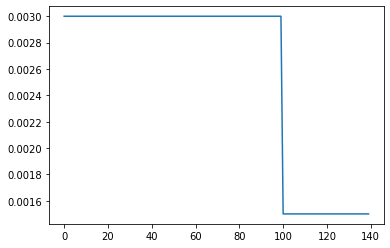

In [26]:
def show_plot(total):
    optimizer = torch.optim.SGD(torch.nn.Linear(2, 1).parameters(), lr=cfg['lr'])
    scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=cfg['milestones'], gamma=cfg['lr_decay'])

    lrs = []

    for i in range(total):
        optimizer.step()
        lrs.append(optimizer.param_groups[0]["lr"])
        scheduler.step()

    plt.plot(range(total), lrs)

    print(lrs[-5:])
    
show_plot(n_epochs)

#### Warmup

In [27]:
def get_cosine_schedule_with_warmup(
    optimizer,
    num_warmup_steps: int,
    num_training_steps: int,
    num_cycles: float = 0.5,
    last_epoch: int = -1,
):
    """
    Create a schedule with a learning rate that decreases following the values of the cosine function between the
    initial lr set in the optimizer to 0, after a warmup period during which it increases linearly between 0 and the
    initial lr set in the optimizer.

    Args:
        optimizer (:class:`~torch.optim.Optimizer`):
        The optimizer for which to schedule the learning rate.
        num_warmup_steps (:obj:`int`):
        The number of steps for the warmup phase.
        num_training_steps (:obj:`int`):
        The total number of training steps.
        num_cycles (:obj:`float`, `optional`, defaults to 0.5):
        The number of waves in the cosine schedule (the defaults is to just decrease from the max value to 0
        following a half-cosine).
        last_epoch (:obj:`int`, `optional`, defaults to -1):
        The index of the last epoch when resuming training.

    Return:
        :obj:`torch.optim.lr_scheduler.LambdaLR` with the appropriate schedule.
    """
    def lr_lambda(current_step, lowerbound=3e-3):
        # Warmup
        if current_step < num_warmup_steps:
            return max(lowerbound, float(current_step) / float(max(1, num_warmup_steps)))
        # decadence
        progress = float(current_step - num_warmup_steps) / float(
            max(1, num_training_steps - num_warmup_steps)
        )
        return max(
            lowerbound, 0.5 * (1.0 + math.cos(math.pi * float(num_cycles) * 2.0 * progress))
        )

    return torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda, last_epoch)

[9e-06, 0.00021428571428571427, 0.00042857142857142855, 0.0006428571428571428, 0.0008571428571428571]
[1.1641190099741905e-05, 9e-06, 9e-06, 9e-06, 9e-06]


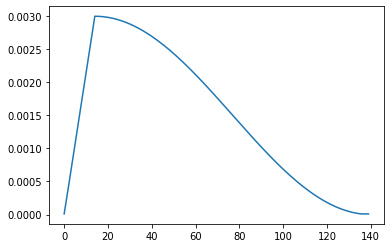

In [28]:
def show_plot(total):
    optimizer = torch.optim.SGD(torch.nn.Linear(2, 1).parameters(), lr=cfg['lr'])
    scheduler = get_cosine_schedule_with_warmup(optimizer, total//10, total)

    lrs = []

    for i in range(total):
        optimizer.step()
        lrs.append(optimizer.param_groups[0]["lr"])
        scheduler.step()

    plt.plot(range(total), lrs)

    print(lrs[:5])
    print(lrs[-5:])
    
show_plot(n_epochs)

In [ ]:
%%script false --no-raise-error

# Initialize optimizer, you may fine-tune some hyperparameters such as learning rate on your own.
optimizer = torch.optim.Adam(student_model.parameters(), lr=cfg['lr'], weight_decay=cfg['weight_decay']) 
# optimizer = torch.optim.SGD(student_model.parameters(), 
#                             lr = cfg['lr'], 
#                             momentum = cfg['momentum'], 
#                             weight_decay = cfg['weight_decay'],
#                             nesterov = True)
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=cfg['milestones'], gamma=cfg['lr_decay'])

In [ ]:
%%script false --no-raise-error

# Initialize a model, and put it on the device specified.
student_model.to(device)
teacher_model.to(device) # MEDIUM BASELINE

# Initialize trackers, these are not parameters and should not be changed
stale = 0
best_acc = 0.0

# teacher_model.eval()  # MEDIUM BASELINE
for epoch in range(n_epochs):

    # ---------- Training ----------
    # Make sure the model is in train mode before training.
    student_model.train()
    teacher_model.eval()

    # These are used to record information in training.
    train_loss = []
    train_accs = []
    train_lens = []

    for batch in tqdm(train_loader):

        # A batch consists of image data and corresponding labels.
        imgs, labels = batch
        imgs = imgs.to(device)
        labels = labels.to(device)
        #imgs = imgs.half()
        #print(imgs.shape,labels.shape)

        # Forward the data. (Make sure data and model are on the same device.)
        with torch.no_grad():  # MEDIUM BASELINE
            teacher_features, teacher_logits = teacher_model(imgs)  # MEDIUM BASELINE
        
        features, logits = student_model(imgs)

        # Calculate the cross-entropy loss.
        # We don't need to apply softmax before computing cross-entropy as it is done automatically.
#         loss = loss_fn(logits, labels, features, teacher_features, lamda=cfg['lamda'])
        loss = loss_fn(logits, labels, teacher_logits, alpha=cfg['alpha'], T=cfg['temperature'])
#         loss = loss_fn(logits, labels) # SIMPLE BASELINE
        # Gradients stored in the parameters in the previous step should be cleared out first.
        optimizer.zero_grad()

        # Compute the gradients for parameters.
        loss.backward()

        # Clip the gradient norms for stable training.
        grad_norm = nn.utils.clip_grad_norm_(student_model.parameters(), max_norm=cfg['grad_norm_max'])

        # Update the parameters with computed gradients.
        optimizer.step()

        # Compute the accuracy for current batch.
        acc = (logits.argmax(dim=-1) == labels).float().sum()

        # Record the loss and accuracy.
        train_batch_len = len(imgs)
        train_loss.append(loss.item() * train_batch_len)
        train_accs.append(acc)
        train_lens.append(train_batch_len)
        
    train_loss = sum(train_loss) / sum(train_lens)
    train_acc = sum(train_accs) / sum(train_lens)

    # Print the information.
    log(f"[ Train | {epoch + 1:03d}/{n_epochs:03d} ] loss = {train_loss:.5f}, acc = {train_acc:.5f} lr = {optimizer.param_groups[0]['lr']:.4f}")
    
    scheduler.step()

    # ---------- Validation ----------
    # Make sure the model is in eval mode so that some modules like dropout are disabled and work normally.
    student_model.eval()

    # These are used to record information in validation.
    valid_loss = []
    valid_accs = []
    valid_lens = []

    # Iterate the validation set by batches.
    for batch in tqdm(valid_loader):

        # A batch consists of image data and corresponding labels.
        imgs, labels = batch
        imgs = imgs.to(device)
        labels = labels.to(device)

        # We don't need gradient in validation.
        # Using torch.no_grad() accelerates the forward process.
        with torch.no_grad():
            features, logits = student_model(imgs)
            teacher_features, teacher_logits = teacher_model(imgs) # MEDIUM BASELINE

        # We can still compute the loss (but not the gradient).
#         loss = loss_fn(logits, labels, features, teacher_features, lamda=cfg['lamda'])
        loss = loss_fn(logits, labels, teacher_logits, alpha=cfg['alpha'], T=cfg['temperature']) # MEDIUM BASELINE
#         loss = loss_fn(logits, labels) # SIMPLE BASELINE

        # Compute the accuracy for current batch.
        acc = (logits.argmax(dim=-1) == labels).float().sum()

        # Record the loss and accuracy.
        batch_len = len(imgs)
        valid_loss.append(loss.item() * batch_len)
        valid_accs.append(acc)
        valid_lens.append(batch_len)
        #break

    # The average loss and accuracy for entire validation set is the average of the recorded values.
    valid_loss = sum(valid_loss) / sum(valid_lens)
    valid_acc = sum(valid_accs) / sum(valid_lens)

    # update logs
    
    if valid_acc > best_acc:
        log(f"[ Valid | {epoch + 1:03d}/{n_epochs:03d} ] loss = {valid_loss:.5f}, acc = {valid_acc:.5f} -> best")
    else:
        log(f"[ Valid | {epoch + 1:03d}/{n_epochs:03d} ] loss = {valid_loss:.5f}, acc = {valid_acc:.5f}")


    # save models
    if valid_acc > best_acc:
        log(f"Best model found at epoch {epoch+1}, saving model")
        torch.save(student_model.state_dict(), f"{save_path}/student_best.ckpt") # only save best to prevent output memory exceed error
        best_acc = valid_acc
        stale = 0
    else:
        stale += 1
        if stale > patience:
            log(f"No improvment {patience} consecutive epochs, early stopping")
            break
log("Finish training")
log_fw.close()

#### DML
Deep Mutual Learning

https://openaccess.thecvf.com/content_cvpr_2018/papers/Zhang_Deep_Mutual_Learning_CVPR_2018_paper.pdf

In [ ]:
# %%script false --no-raise-error

def loss_fn_dml(input, target):
    return F.kl_div(F.log_softmax(input, dim=1),
                    F.softmax(target, dim=1),
                    log_target=False,
                    reduction='batchmean')

student_model1 = get_student_model()
student_model2 = get_student_model()
# student_model1.load_state_dict(torch.load("../input/hw13tmp/outputs/ResNet18_prune_MIX_DML/student_another.ckpt", map_location=device))
# student_model2.load_state_dict(torch.load("../input/hw13tmp/outputs/ResNet18_prune_MIX_DML/student_best.ckpt", map_location=device))

optimizer1 = torch.optim.Adam(student_model1.parameters(), lr=cfg['lr'], weight_decay=cfg['weight_decay']) 
optimizer2 = torch.optim.Adam(student_model2.parameters(), lr=cfg['lr'], weight_decay=cfg['weight_decay']) 

# scheduler1 = torch.optim.lr_scheduler.MultiStepLR(optimizer1, milestones=cfg['milestones'], gamma=cfg['lr_decay'])
# scheduler2 = torch.optim.lr_scheduler.MultiStepLR(optimizer2, milestones=cfg['milestones'], gamma=cfg['lr_decay'])
scheduler1 = get_cosine_schedule_with_warmup(optimizer1, n_epochs//10, n_epochs)
scheduler2 = get_cosine_schedule_with_warmup(optimizer2, n_epochs//10, n_epochs)

In [ ]:
%%script false --no-raise-error

teacher_features_mid = []
def hook(self, input, output):
    teacher_features_mid.clear()
    teacher_features_mid.append(output.clone())
    
handle = teacher_model.layer2.register_forward_hook(hook)

# Initialize a model, and put it on the device specified.
student_model1.to(device)
student_model2.to(device)
teacher_model.to(device)

# Initialize trackers, these are not parameters and should not be changed
stale = 0
best_acc = 0

# teacher_model.eval()  # MEDIUM BASELINE
for epoch in range(n_epochs):

    # ---------- Training ----------
    # Make sure the model is in train mode before training.
    student_model1.train()
    student_model2.train()
    teacher_model.eval()

    # These are used to record information in training.
    train_loss = []
    train_accs = []
    train_lens = []

    for batch in tqdm(train_loader):

        # A batch consists of image data and corresponding labels.
        imgs, labels = batch
        imgs = imgs.to(device)
        labels = labels.to(device)
        #imgs = imgs.half()
        #print(imgs.shape,labels.shape)

        # Forward the data. (Make sure data and model are on the same device.)
        with torch.no_grad():  # MEDIUM BASELINE
            teacher_features, teacher_logits = teacher_model(imgs)  # MEDIUM BASELINE
        
        features1_mid, features1, logits1 = student_model1(imgs)
        features2_mid, features2, logits2 = student_model2(imgs)
        
        # student_model1
        loss1 = loss_fn_dml(logits1, logits2.detach()) + loss_fn(labels, 
                                                                 features1_mid.view(cfg['batch_size'],-1), 
                                                                 teacher_features_mid[0].view(cfg['batch_size'],-1),
                                                                 features1, 
                                                                 teacher_features, 
                                                                 logits1, 
                                                                 teacher_logits, T=cfg['temperature'])
        optimizer1.zero_grad()
        loss1.backward()
        optimizer1.step()
        
        # student_model2
        loss2 = loss_fn_dml(logits2, logits1.detach()) + loss_fn(labels, 
                                                                 features2_mid.view(cfg['batch_size'],-1), 
                                                                 teacher_features_mid[0].view(cfg['batch_size'],-1),
                                                                 features2, 
                                                                 teacher_features, 
                                                                 logits2, 
                                                                 teacher_logits, T=cfg['temperature'])
        optimizer2.zero_grad()
        loss2.backward()
        optimizer2.step()
        
        # Compute the accuracy for current batch.
        acc1 = (logits1.argmax(dim=-1) == labels).float().sum()
        acc2 = (logits2.argmax(dim=-1) == labels).float().sum()

        # Record the loss and accuracy.
        train_batch_len = len(imgs)
        train_loss.append((loss1.item() * train_batch_len, loss2.item() * train_batch_len))
        train_accs.append((acc1.item(), acc2.item()))
        train_lens.append(train_batch_len)
        
    train_loss = np.sum(list(zip(*train_loss)), axis=1) / sum(train_lens)
    train_acc = np.sum(list(zip(*train_accs)), axis=1) / sum(train_lens)

    # Print the information.
    log(f"[ Train | {epoch + 1:03d}/{n_epochs:03d} ] loss = {train_loss[0]:.5f}|{train_loss[1]:.5f}, acc = {train_acc[0]:.5f}|{train_acc[1]:.5f}, lr = {optimizer1.param_groups[0]['lr']:.6f}|{optimizer2.param_groups[0]['lr']:.6f}")
    
    scheduler1.step()
    scheduler2.step()

    # ---------- Validation ----------
    # Make sure the model is in eval mode so that some modules like dropout and Batch Normalization are disabled and work normally.
    # !important, would affect training result, because of Batch Normalization
    student_model1.eval()
    student_model2.eval()

    # These are used to record information in validation.
    valid_loss = []
    valid_accs = []
    valid_lens = []

    # Iterate the validation set by batches.
    for batch in tqdm(valid_loader):

        # A batch consists of image data and corresponding labels.
        imgs, labels = batch
        imgs = imgs.to(device)
        labels = labels.to(device)

        # We don't need gradient in validation.
        # Using torch.no_grad() accelerates the forward process.
        with torch.no_grad():
            features1_mid, features1, logits1 = student_model1(imgs)
            features2_mid, features2, logits2 = student_model2(imgs)
            teacher_features, teacher_logits = teacher_model(imgs) # MEDIUM BASELINE

        # We can still compute the loss (but not the gradient).
        loss1 = loss_fn_dml(logits1, logits2.detach()) + loss_fn(labels, 
                                                                 features1_mid.view(cfg['batch_size'],-1), 
                                                                 teacher_features_mid[0].view(cfg['batch_size'],-1),
                                                                 features1, 
                                                                 teacher_features, 
                                                                 logits1, 
                                                                 teacher_logits, T=cfg['temperature'])
        loss2 = loss_fn_dml(logits2, logits1.detach()) + loss_fn(labels, 
                                                                 features2_mid.view(cfg['batch_size'],-1), 
                                                                 teacher_features_mid[0].view(cfg['batch_size'],-1),
                                                                 features2, 
                                                                 teacher_features, 
                                                                 logits2, 
                                                                 teacher_logits, T=cfg['temperature'])
#         loss1 = loss_fn(logits1, labels, teacher_logits, alpha=cfg['alpha'], T=cfg['temperature'])
#         loss2 = loss_fn(logits2, labels, teacher_logits, alpha=cfg['alpha'], T=cfg['temperature'])

        # Compute the accuracy for current batch.
        acc1 = (logits1.argmax(dim=-1) == labels).float().sum()
        acc2 = (logits2.argmax(dim=-1) == labels).float().sum()

        # Record the loss and accuracy.
        batch_len = len(imgs)
        valid_loss.append((loss1.item() * batch_len, loss2.item() * batch_len))
        valid_accs.append((acc1.item(), acc2.item()))
        valid_lens.append(batch_len)
        #break

    # The average loss and accuracy for entire validation set is the average of the recorded values.
    valid_loss = np.sum(list(zip(*valid_loss)), axis=1) / sum(valid_lens)
    valid_acc = np.sum(list(zip(*valid_accs)), axis=1) / sum(valid_lens)

    # update logs
    
    idx = np.argmax(valid_acc)
    if valid_acc[idx] > best_acc:
        log(f"[ Valid | {epoch + 1:03d}/{n_epochs:03d} ] loss = {valid_loss[0]:.5f}|{valid_loss[1]:.5f}, acc = {valid_acc[0]:.5f}|{valid_acc[1]:.5f} ------------------------------> best")
    else:
        log(f"[ Valid | {epoch + 1:03d}/{n_epochs:03d} ] loss = {valid_loss[0]:.5f}|{valid_loss[1]:.5f}, acc = {valid_acc[0]:.5f}|{valid_acc[1]:.5f}")


    # save models
    if valid_acc[idx] > best_acc:
        log(f"Best model found at epoch {epoch+1}, saving model")
        if idx == 0:
            torch.save(student_model1.state_dict(), f"{save_path}/student_best.ckpt") # only save best to prevent output memory exceed error
            torch.save(student_model2.state_dict(), f"{save_path}/student_another.ckpt")
        else:
            torch.save(student_model1.state_dict(), f"{save_path}/student_another.ckpt")
            torch.save(student_model2.state_dict(), f"{save_path}/student_best.ckpt") # only save best to prevent output memory exceed error
        best_acc = valid_acc[idx]
        stale = 0
    else:
        stale += 1
        if stale > patience:
            log(f"No improvment {patience} consecutive epochs, early stopping")
            break
log("Finish training")
log_fw.close()
handle.remove()

In [ ]:
# %%script false --no-raise-error
# valid by eval_loader

# Initialize a model, and put it on the device specified.
student_model1.to(device)
student_model2.to(device)
teacher_model.to(device)

# Initialize trackers, these are not parameters and should not be changed
stale = 0
best_acc = 0

# teacher_model.eval()  # MEDIUM BASELINE
for epoch in range(n_epochs):

    # ---------- Training ----------
    # Make sure the model is in train mode before training.
    student_model1.train()
    student_model2.train()
    teacher_model.eval()

    # These are used to record information in training.
    train_loss = []
    train_accs = []
    train_lens = []

    for batch in tqdm(train_loader):

        # A batch consists of image data and corresponding labels.
        imgs, labels = batch
        imgs = imgs.to(device)
        labels = labels.to(device)
        #imgs = imgs.half()
        #print(imgs.shape,labels.shape)

        # Forward the data. (Make sure data and model are on the same device.)
        with torch.no_grad():  # MEDIUM BASELINE
            teacher_features, teacher_logits = teacher_model(imgs)  # MEDIUM BASELINE
        
        features1_mid, features1, logits1 = student_model1(imgs)
        features2_mid, features2, logits2 = student_model2(imgs)
        
        # student_model1
        loss1 = loss_fn_dml(logits1, logits2.detach()) + loss_fn(labels, 
                                                                 None, 
                                                                 None,
                                                                 features1, 
                                                                 teacher_features, 
                                                                 logits1, 
                                                                 teacher_logits, T=cfg['temperature'])
        optimizer1.zero_grad()
        loss1.backward()
        optimizer1.step()
        
        # student_model2
        loss2 = loss_fn_dml(logits2, logits1.detach()) + loss_fn(labels, 
                                                                 None, 
                                                                 None,
                                                                 features2, 
                                                                 teacher_features, 
                                                                 logits2, 
                                                                 teacher_logits, T=cfg['temperature'])
        optimizer2.zero_grad()
        loss2.backward()
        optimizer2.step()
        
        # Compute the accuracy for current batch.
        acc1 = (logits1.argmax(dim=-1) == labels).float().sum()
        acc2 = (logits2.argmax(dim=-1) == labels).float().sum()

        # Record the loss and accuracy.
        train_batch_len = len(imgs)
        train_loss.append((loss1.item() * train_batch_len, loss2.item() * train_batch_len))
        train_accs.append((acc1.item(), acc2.item()))
        train_lens.append(train_batch_len)
        
    train_loss = np.sum(list(zip(*train_loss)), axis=1) / sum(train_lens)
    train_acc = np.sum(list(zip(*train_accs)), axis=1) / sum(train_lens)

    # Print the information.
    log(f"[ Train | {epoch + 1:03d}/{n_epochs:03d} ] loss = {train_loss[0]:.5f}|{train_loss[1]:.5f}, acc = {train_acc[0]:.5f}|{train_acc[1]:.5f}, lr = {optimizer1.param_groups[0]['lr']:.6f}|{optimizer2.param_groups[0]['lr']:.6f}")
    
    scheduler1.step()
    scheduler2.step()

    # ---------- Validation ----------
    # Make sure the model is in eval mode so that some modules like dropout and Batch Normalization are disabled and work normally.
    # !important, would affect training result, because of Batch Normalization
    student_model1.eval()
    student_model2.eval()

    # These are used to record information in validation.
    eval_accs = []
    eval_lens = []

    # Iterate the validation set by batches.
    for batch in tqdm(eval_loader):
        imgs, _ = batch
        imgs = imgs.to(device)
        
        # We don't need gradient in validation.
        # Using torch.no_grad() accelerates the forward process.
        with torch.no_grad():
            _, _, logits1 = student_model1(imgs)
            _, _, logits2 = student_model2(imgs)
            _, teacher_logits = teacher_model(imgs) # MEDIUM BASELINE

        labels = teacher_logits.argmax(dim=-1)
        # Compute the accuracy for current batch.
        acc1 = (logits1.argmax(dim=-1) == labels).float().sum()
        acc2 = (logits2.argmax(dim=-1) == labels).float().sum()

        # Record the loss and accuracy.
        batch_len = len(imgs)
        eval_accs.append((acc1.item(), acc2.item()))
        eval_lens.append(batch_len)
        #break

    # The average loss and accuracy for entire validation set is the average of the recorded values.
    eval_acc = np.sum(list(zip(*eval_accs)), axis=1) / sum(eval_lens)

    # update logs
    idx = np.argmax(eval_acc)
    if eval_acc[idx] > best_acc:
        log(f"[ Eval | {epoch + 1:03d}/{n_epochs:03d} ] , acc = {eval_acc[0]:.5f}|{eval_acc[1]:.5f} ------------------------------> best")
    else:
        log(f"[ Eval | {epoch + 1:03d}/{n_epochs:03d} ] , acc = {eval_acc[0]:.5f}|{eval_acc[1]:.5f}")


    # save models
    if eval_acc[idx] > best_acc:
        log(f"Best model found at epoch {epoch+1}, saving model")
        if idx == 0:
            torch.save(student_model1.state_dict(), f"{save_path}/student_best.ckpt") # only save best to prevent output memory exceed error
            torch.save(student_model2.state_dict(), f"{save_path}/student_another.ckpt")
        else:
            torch.save(student_model1.state_dict(), f"{save_path}/student_another.ckpt")
            torch.save(student_model2.state_dict(), f"{save_path}/student_best.ckpt") # only save best to prevent output memory exceed error
        best_acc = eval_acc[idx]
        stale = 0
    else:
        stale += 1
        if stale > patience:
            log(f"No improvment {patience} consecutive epochs, early stopping")
            break
log("Finish training")
log_fw.close()

#### Label Refinery

In [ ]:
%%script false --no-raise-error

def loss_fn_label_refinery(input, target):
    return F.kl_div(F.log_softmax(input, dim=1),
                    F.softmax(target, dim=1),
                    log_target=False,
                    reduction='batchmean')

In [ ]:
%%script false --no-raise-error

pre_best_acc = -np.inf
for i in range(5):
    teacher_model = get_student_model()
    ckpt_path = f"{save_path}/student_best.ckpt" # the ckpt path of the best student model.
    teacher_model.load_state_dict(torch.load(ckpt_path, map_location='cpu')) # load the state dict and set it to the student model
    student_model1 = get_student_model()
    student_model2 = get_student_model()
    
    optimizer1 = torch.optim.Adam(student_model1.parameters(), lr=cfg['lr'], weight_decay=cfg['weight_decay']) 
    optimizer2 = torch.optim.Adam(student_model2.parameters(), lr=cfg['lr'], weight_decay=cfg['weight_decay']) 

    scheduler1 = torch.optim.lr_scheduler.MultiStepLR(optimizer1, milestones=cfg['milestones'], gamma=cfg['lr_decay'])
    scheduler2 = torch.optim.lr_scheduler.MultiStepLR(optimizer2, milestones=cfg['milestones'], gamma=cfg['lr_decay'])

    # Initialize a model, and put it on the device specified.
    student_model1.to(device)
    student_model2.to(device)
    teacher_model.to(device)

    # Initialize trackers, these are not parameters and should not be changed
    stale = 0
    best_acc = get_valid_acc(teacher_model)
    log(f"Refinery {i} => best_acc: {best_acc}")
    if pre_best_acc >= best_acc:
        log(f"No improvment at {i}, early stopping")
    else:
        pre_best_acc = best_acc

    # teacher_model.eval()  # MEDIUM BASELINE
    for epoch in range(n_epochs):

        # ---------- Training ----------
        # Make sure the model is in train mode before training.
        student_model1.train()
        student_model2.train()
        teacher_model.eval()

        # These are used to record information in training.
        train_loss = []
        train_accs = []
        train_lens = []

        for batch in tqdm(train_loader):

            # A batch consists of image data and corresponding labels.
            imgs, labels = batch
            imgs = imgs.to(device)
            labels = labels.to(device)
            #imgs = imgs.half()
            #print(imgs.shape,labels.shape)

            # Forward the data. (Make sure data and model are on the same device.)
            with torch.no_grad():  # MEDIUM BASELINE
                teacher_features_mid, teacher_features, teacher_logits = teacher_model(imgs)  # MEDIUM BASELINE

            features1_mid, features1, logits1 = student_model1(imgs)
            features2_mid, features2, logits2 = student_model2(imgs)

            # student_model1
            loss1 = loss_fn_dml(logits1, logits2.detach()) + loss_fn_label_refinery(logits1, teacher_logits.detach())
            optimizer1.zero_grad()
            loss1.backward()
            optimizer1.step()

            # student_model2
            loss2 = loss_fn_dml(logits2, logits1.detach()) + loss_fn_label_refinery(logits2, teacher_logits.detach())
            optimizer2.zero_grad()
            loss2.backward()
            optimizer2.step()

            # Compute the accuracy for current batch.
            acc1 = (logits1.argmax(dim=-1) == labels).float().sum()
            acc2 = (logits2.argmax(dim=-1) == labels).float().sum()

            # Record the loss and accuracy.
            train_batch_len = len(imgs)
            train_loss.append((loss1.item() * train_batch_len, loss2.item() * train_batch_len))
            train_accs.append((acc1.item(), acc2.item()))
            train_lens.append(train_batch_len)

        train_loss = np.sum(list(zip(*train_loss)), axis=1) / sum(train_lens)
        train_acc = np.sum(list(zip(*train_accs)), axis=1) / sum(train_lens)

        # Print the information.
        log(f"[ Train | {epoch + 1:03d}/{n_epochs:03d} ] loss = {train_loss[0]:.5f}|{train_loss[1]:.5f}, acc = {train_acc[0]:.5f}|{train_acc[1]:.5f}, lr = {optimizer1.param_groups[0]['lr']:.6f}|{optimizer2.param_groups[0]['lr']:.6f}")

        scheduler1.step()
        scheduler2.step()

        # ---------- Validation ----------
        # Make sure the model is in eval mode so that some modules like dropout and Batch Normalization are disabled and work normally.
        # !important, would affect training result, because of Batch Normalization
        student_model1.eval()
        student_model2.eval()

        # These are used to record information in validation.
        valid_loss = []
        valid_accs = []
        valid_lens = []

        # Iterate the validation set by batches.
        for batch in tqdm(valid_loader):

            # A batch consists of image data and corresponding labels.
            imgs, labels = batch
            imgs = imgs.to(device)
            labels = labels.to(device)

            # We don't need gradient in validation.
            # Using torch.no_grad() accelerates the forward process.
            with torch.no_grad():
                features1_mid, features1, logits1 = student_model1(imgs)
                features2_mid, features2, logits2 = student_model2(imgs)
                teacher_features_mid, teacher_features, teacher_logits = teacher_model(imgs)

            # We can still compute the loss (but not the gradient).
            loss1 = loss_fn_dml(logits1, logits2.detach()) + loss_fn_label_refinery(logits1, teacher_logits.detach())
            loss2 = loss_fn_dml(logits2, logits1.detach()) + loss_fn_label_refinery(logits2, teacher_logits.detach())

            # Compute the accuracy for current batch.
            acc1 = (logits1.argmax(dim=-1) == labels).float().sum()
            acc2 = (logits2.argmax(dim=-1) == labels).float().sum()

            # Record the loss and accuracy.
            batch_len = len(imgs)
            valid_loss.append((loss1.item() * batch_len, loss2.item() * batch_len))
            valid_accs.append((acc1.item(), acc2.item()))
            valid_lens.append(batch_len)
            #break

        # The average loss and accuracy for entire validation set is the average of the recorded values.
        valid_loss = np.sum(list(zip(*valid_loss)), axis=1) / sum(valid_lens)
        valid_acc = np.sum(list(zip(*valid_accs)), axis=1) / sum(valid_lens)

        # update logs

        idx = np.argmax(valid_acc)
        if valid_acc[idx] > best_acc:
            log(f"[ Valid | {epoch + 1:03d}/{n_epochs:03d} ] loss = {valid_loss[0]:.5f}|{valid_loss[1]:.5f}, acc = {valid_acc[0]:.5f}|{valid_acc[1]:.5f} ------------------------------> best")
        else:
            log(f"[ Valid | {epoch + 1:03d}/{n_epochs:03d} ] loss = {valid_loss[0]:.5f}|{valid_loss[1]:.5f}, acc = {valid_acc[0]:.5f}|{valid_acc[1]:.5f}")


        # save models
        if valid_acc[idx] > best_acc:
            log(f"Best model found at epoch {epoch+1}, saving model")
            if idx == 0:
                torch.save(student_model1.state_dict(), f"{save_path}/student_best.ckpt") # only save best to prevent output memory exceed error
                torch.save(student_model2.state_dict(), f"{save_path}/student_another.ckpt")
            else:
                torch.save(student_model1.state_dict(), f"{save_path}/student_another.ckpt")
                torch.save(student_model2.state_dict(), f"{save_path}/student_best.ckpt") # only save best to prevent output memory exceed error
            best_acc = valid_acc[idx]
            stale = 0
        else:
            stale += 1
            if stale > patience:
                log(f"No improvment {patience} consecutive epochs, early stopping")
                break
log("Finish training")
log_fw.close()
handle.remove()

### Inference
load the best model of the experiment and generate submission.csv

In [ ]:
%%script false --no-raise-error

# create dataloader for evaluation
eval_set = FoodDataset(os.path.join(cfg['dataset_root'], "evaluation"), tfm=test_tfm)
eval_loader = DataLoader(eval_set, batch_size=cfg['batch_size'], shuffle=False, num_workers=0, pin_memory=True)

In [ ]:
# Load model from {exp_name}/student_best.ckpt
student_model_best = get_student_model() # get a new student model to avoid reference before assignment.
ckpt_path = f"{save_path}/student_best.ckpt" # the ckpt path of the best student model.
student_model_best.load_state_dict(torch.load(ckpt_path, map_location='cpu')) # load the state dict and set it to the student model
student_model_best.to(device) # set the student model to device

# Start evaluate
student_model_best.eval()
eval_preds = [] # storing predictions of the evaluation dataset

# Iterate the validation set by batches.
for batch in tqdm(eval_loader):
    # A batch consists of image data and corresponding labels.
    imgs, _ = batch
    # We don't need gradient in evaluation.
    # Using torch.no_grad() accelerates the forward process.
    with torch.no_grad():
        _, _, logits = student_model_best(imgs.to(device))
        preds = list(logits.argmax(dim=-1).squeeze().cpu().numpy())
    # loss and acc can not be calculated because we do not have the true labels of the evaluation set.
    eval_preds += preds

def pad4(i):
    return "0"*(4-len(str(i))) + str(i)

# Save prediction results
ids = [pad4(i) for i in range(0,len(eval_set))]
categories = eval_preds

df = pd.DataFrame()
df['Id'] = ids
df['Category'] = categories
df.to_csv(f"{save_path}/submission.csv", index=False) # now you can download the submission.csv and upload it to the kaggle competition.

> Don't forget to answer the report questions on GradeScope!

### Report Questions - 3-1
Please reference to this pytorch network pruning tutorial and the provided sample code to adopt network pruning on your teacher network (you can also
use the provided one). Plot the graph like below to indicate the relationship between pruning ratio and accuracy (use validation set).

https://pytorch.org/tutorials/intermediate/pruning_tutorial.html

In [ ]:
valid_set = FoodDataset(os.path.join(cfg['dataset_root'], "validation"), tfm=test_tfm)
valid_loader = DataLoader(valid_set, batch_size=cfg['batch_size'], shuffle=False, num_workers=0, pin_memory=True)

In [ ]:
import torch.nn.utils.prune as prune

# Load provided teacher model (model architecture: resnet18, num_classes=11, test-acc ~= 89.9%)
teacher_model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet18', pretrained=False, num_classes=11)
# load state dict
teacher_ckpt_path = os.path.join(cfg['dataset_root'], "resnet18_teacher.ckpt")
teacher_model.load_state_dict(torch.load(teacher_ckpt_path, map_location='cpu'))
summary(teacher_model, (cfg['batch_size'], 3, 224, 224), device='cpu')

In [ ]:
prune_list = []
for name, module in teacher_model.named_modules():
    if isinstance(module, torch.nn.Conv2d):
        prune_list.append((module, "weight"))
    elif isinstance(module, torch.nn.Linear):
        prune_list.append((module, "weight"))
        prune_list.append((module, "bias"))
    elif isinstance(module, torch.nn.BatchNorm2d):
        prune_list.append((module, "weight"))
        prune_list.append((module, "bias"))

pprint(prune_list)

In [ ]:
%%script false --no-raise-error

x = []
y = []

ratio_step = 0.05
for ratio in np.arange(0.0, 1.0, ratio_step):
    x.append(ratio)
    y.append(get_valid_acc(teacher_model, valid_loader, ratio))
    prune.global_unstructured(
        prune_list,
        pruning_method=prune.L1Unstructured,
        amount=ratio_step,
    )
    
plt.figure(figsize=(20, 10))
ax = plt.plot(x, y, marker="o")
plt.title("Pruning Ratio v.s. Model Accuracy") # title
plt.ylabel("Model Accuracy") # y label
plt.xlabel("Pruning Ratio") # x label
plt.xticks(x)
plt.show()

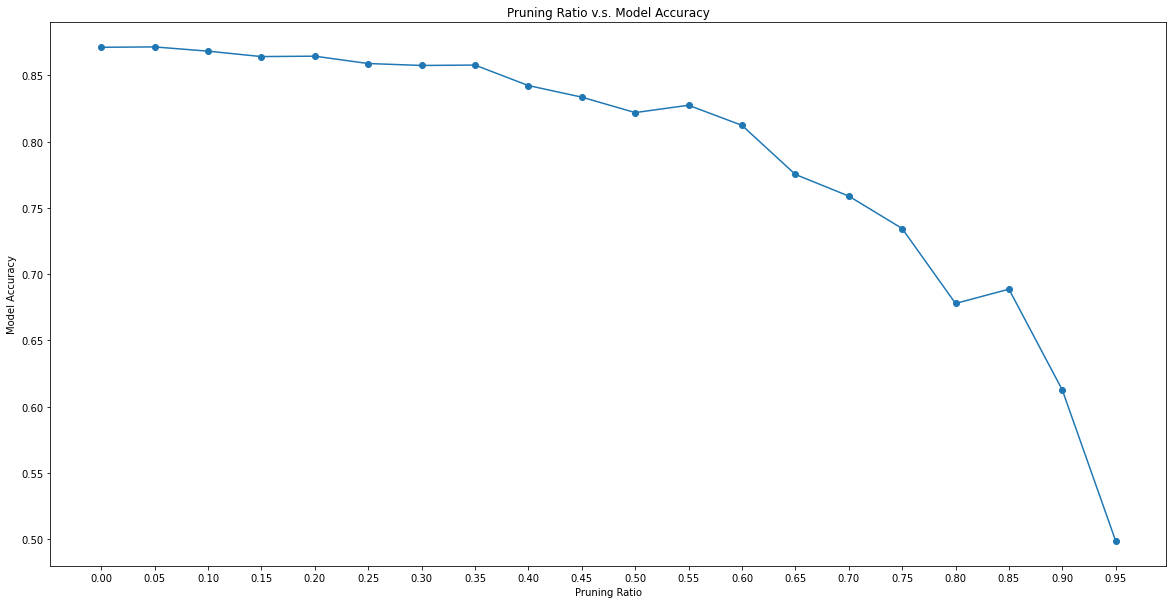

### Report Questions - 3-2
Continue to the previous question, do you think that the implementation of network pruning in the tutorial can speed up inference time? (If you have no idea, we encourage you to implement some inference-time measurement experiments by yourself) 

### Ans: No, see above runing time

### Student Model Prune

In [ ]:
student_model = get_student_model()
student_model.load_state_dict(torch.load("../input/hw13tmp/outputs/ResNet18_prune_MIX_DML/student_best.ckpt", map_location=device))
print(get_valid_acc(student_model, valid_loader))
summary(student_model, (cfg['batch_size'], 3, 224, 224), device='cpu')

In [ ]:
import torch.nn.utils.prune as prune

prune_list = []
for name, module in student_model.named_modules():
    if isinstance(module, torch.nn.Conv2d):
        prune_list.append((module, "weight"))
    elif isinstance(module, torch.nn.Linear):
        prune_list.append((module, "weight"))
        prune_list.append((module, "bias"))
    elif isinstance(module, torch.nn.BatchNorm2d):
        prune_list.append((module, "weight"))
        prune_list.append((module, "bias"))

pprint(prune_list)

In [ ]:
%%script false --no-raise-error

x = []
y = []

ratio_step = 0.05
for ratio in np.arange(0.0, 1.0, ratio_step):
    x.append(ratio)
    y.append(get_valid_acc(student_model, valid_loader, ratio))
    prune.global_unstructured(
        prune_list,
        pruning_method=prune.L1Unstructured,
        amount=ratio_step,
    )
    
plt.figure(figsize=(20, 10))
ax = plt.plot(x, y, marker="o")
plt.title("Pruning Ratio v.s. Model Accuracy") # title
plt.ylabel("Model Accuracy") # y label
plt.xlabel("Pruning Ratio") # x label
plt.xticks(x)
plt.show()

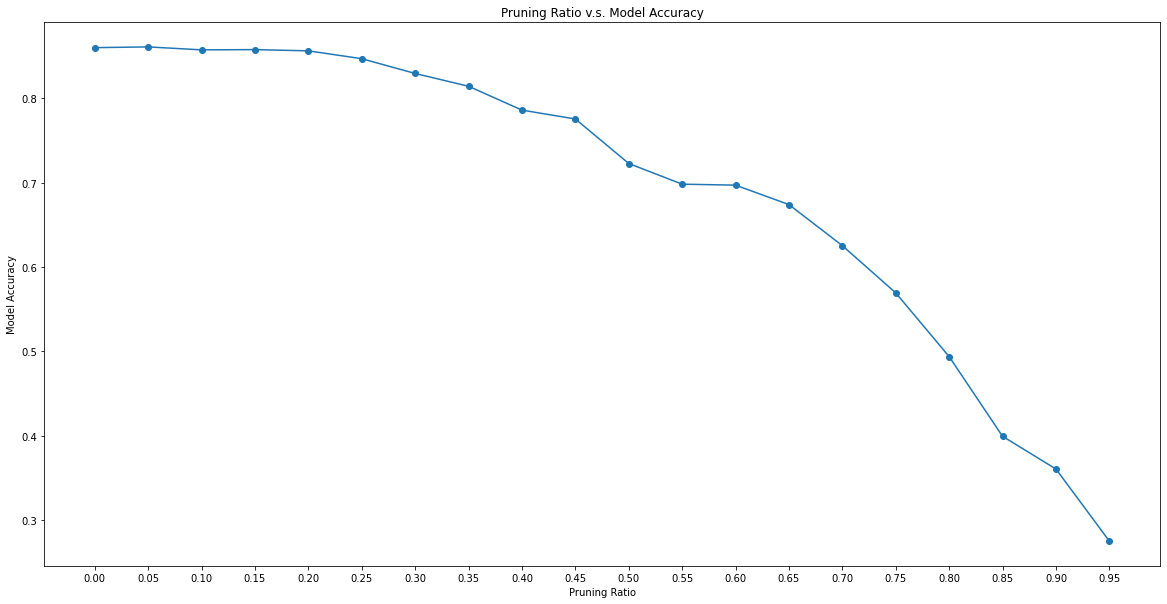